# 2018

In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [3]:
def ranking(team):
    first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
    second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
    third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
    fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
    fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']
    lst = [first_teams, second_teams, third_teams, fourth_teams, fifth_teams]
    for i in range(len(lst)):
        teams = lst[i]
        if team in teams:
            return i + 1

In [4]:
case_expected_score_dict = dict(pd.read_csv(os.path.join(ROOT_DIR, "case_expected_score.csv"), dtype=object).values)
case_expected_score_dict = dict([[key, float(value)] for key, value in case_expected_score_dict.items()])

def weighted_score(case, score):
    """
    lst : (Stの状況, 直後の得点)
    """
    return score / case_expected_score_dict[case]

In [5]:
case_expected_score_dict

{'0000': 0.033157798382493886,
 '0001': 0.5030241935483871,
 '0010': 0.16194895591647332,
 '0011': 0.648729446935725,
 '0100': 0.08679945323179067,
 '0101': 0.6521246458923513,
 '0110': 0.22460824143934996,
 '0111': 0.8508327299058653,
 '1000': 0.033681354332566506,
 '1001': 0.511204481792717,
 '1010': 0.18310955438801324,
 '1011': 0.6151399491094147,
 '1100': 0.08819357192072305,
 '1101': 0.5884353741496599,
 '1110': 0.2544052863436123,
 '1111': 0.7888493475682088,
 '2000': 0.03356242200741279,
 '2001': 0.25295420974889216,
 '2010': 0.2059659090909091,
 '2011': 0.38658829815655893,
 '2100': 0.08848366173051034,
 '2101': 0.31339031339031337,
 '2110': 0.270979967514889,
 '2111': 0.593297974927676}

In [6]:
team = "Rソックス"
"""df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
lst = make_flattened_list(triple)"""

'df = event_df[event_df.攻撃チーム==team]\ntriple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))\nlst = make_flattened_list(triple)'

In [ ]:
def triple_on_score_diff(team, diff_lower, diff_upper, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif int(year) == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif int(year) == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
    lst = make_flattened_list(triple)
    res = []
    for elem in lst:
        my_score = int(elem[1][1])
        opp_score = int(elem[1][2])
        if diff_lower < diff_upper:
            if diff_lower <= my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        elif diff_lower > diff_upper:
            if diff_lower <= my_score - opp_score or my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        else:
            raise "diff_lower == diff_upper"
    return res

## negative facilitation = 負けてることが逆に力になる

## negative facilitaitonを起こしがちなチームは、僅差で負けているとdet時の期待得点が上がる

# 点数気にしない

In [7]:
#imp_list = []
#det_list = []
res_dict1 = dict()
for team in teams_mlb:
    df = df_2018[df_2018.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict1[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

マーリンズ 0.844679912666 0.695222098839
マリナーズ 0.905468816839 0.844746346979
パドレス 0.806578623402 0.916007573781
Rソックス 0.911386576467 0.93712167959
レッズ 0.840547854415 0.714499284529
パイレーツ 0.936734831758 0.704679339415
タイガース 0.827729236297 0.586874101773
オリオールズ 0.906042824138 0.927070766562
インディアンス 1.00784827106 0.990169525977
メッツ 0.871277001881 0.827844631927
ヤンキース 1.16128542128 1.13685642867
カージナルス 0.972290897371 0.830193910803
エンゼルス 0.901477934893 1.08430224374
レイズ 0.712193565687 0.775499011988
ロッキーズ 1.03728886145 1.00270883411
ロイヤルズ 0.956856578375 0.727179229931
Wソックス 0.904289744233 0.912657900919
アスレチックス 0.95909810695 1.10230609272
フィリーズ 0.826993336306 0.790274289458
ナショナルズ 0.933698261654 0.840208990869
カブス 0.800344989279 0.685855024942
Dバックス 1.03161366753 0.860837069788
ツインズ 0.921116825618 0.886260549805
ブルージェイズ 0.862896392348 1.10031556848
ブレーブス 0.951047796162 0.744919713476
アストロズ 0.975676478091 0.971769565515
ブリュワーズ 1.00623017262 0.876985729082
ジャイアンツ 0.725696647321 0.544644867159
ドジャ

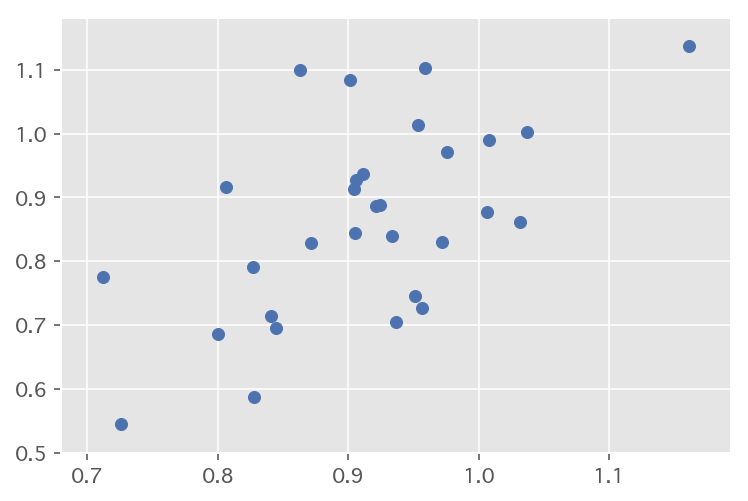

In [8]:
plt.scatter([elem[0] for elem in list(res_dict1.values())], [elem[1] for elem in list(res_dict1.values())])

# 4点差の負け以内

In [9]:
#imp_list = []
#det_list = []
res_dict = dict()
for team in teams_mlb:
    lst = triple_on_score_diff(team, -4, -1, 2018)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

マーリンズ 0.760844238848 0.64883794915
マリナーズ 0.97636350261 0.860807997291
パドレス 0.731802918682 0.990572796565
Rソックス 0.977282547696 1.30063173139
レッズ 0.664465927795 0.694124389136
パイレーツ 0.913573848677 0.618541719491
タイガース 0.73010689773 0.432948475297
オリオールズ 0.878988949432 0.972239518873
インディアンス 1.16057823805 1.03987610912
メッツ 0.806665146236 0.875682906905
ヤンキース 0.927381160313 0.866718476702
カージナルス 0.757886154304 0.774545378461
エンゼルス 0.820922061566 0.877381214223
レイズ 0.450679517418 0.757012680794
ロッキーズ 1.11105115412 0.882931913811
ロイヤルズ 0.717268955669 1.04666525654
Wソックス 0.92856697413 0.998411890544
アスレチックス 0.764722536869 0.845958209404
フィリーズ 0.740690479745 0.873815801233
ナショナルズ 0.611440574827 0.839723266101
カブス 0.935288331836 0.49476541855
Dバックス 0.880036584849 0.704431685631
ツインズ 0.915830464915 0.822898912125
ブルージェイズ 0.820970348035 0.963120236693
ブレーブス 0.936378034634 0.605149114042
アストロズ 0.839169211979 1.01519537842
ブリュワーズ 0.872106578136 0.663403132649
ジャイアンツ 0.905047731546 0.543272234798
ドジ

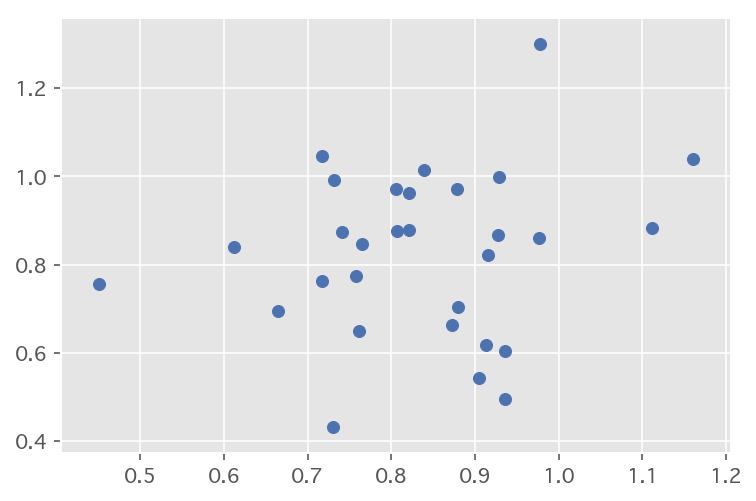

In [10]:
plt.scatter([elem[0] for elem in list(res_dict.values())], [elem[1] for elem in list(res_dict.values())])

In [11]:
# 僅差で負けていると、流れが悪くても頑張るチーム
for team in teams_mlb:
    if res_dict1[team][1] < res_dict[team][1]:
        print(ranking(team), team, res_dict[team][1] - res_dict1[team][1])

3 マリナーズ 0.0160616503119
5 パドレス 0.0745652227837
1 Rソックス 0.363510051804
5 オリオールズ 0.0451687523107
1 インディアンス 0.0497065831443
4 メッツ 0.0478382749774
5 ロイヤルズ 0.319486026606
4 Wソックス 0.085753989625
3 フィリーズ 0.0835415117749
1 アストロズ 0.0434258129072


In [12]:
# 僅差で負けていると、流れが悪いと諦めるチーム
for team in teams_mlb:
    if res_dict1[team][1] > res_dict[team][1]:
        print(ranking(team), team, res_dict[team][1] - res_dict1[team][1])

5 マーリンズ -0.0463841496887
5 レッズ -0.0203748953939
4 パイレーツ -0.0861376199245
3 タイガース -0.153925626475
2 ヤンキース -0.270137951965
3 カージナルス -0.0556485323423
4 エンゼルス -0.20692102952
3 レイズ -0.0184863311946
2 ロッキーズ -0.119776920297
2 アスレチックス -0.256347883317
2 ナショナルズ -0.000485724768024
2 カブス -0.191089606392
3 Dバックス -0.156405384157
2 ツインズ -0.0633616376794
4 ブルージェイズ -0.137195331787
1 ブレーブス -0.139770599433
1 ブリュワーズ -0.213582596433
4 ジャイアンツ -0.0013726323612
1 ドジャース -0.0419667209194
5 レンジャーズ -0.126285452922
